<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implemention-of-network's-interface" data-toc-modified-id="Implemention-of-network's-interface-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implemention of network's interface</a></span><ul class="toc-item"><li><span><a href="#Input-Class" data-toc-modified-id="Input-Class-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Input Class</a></span></li><li><span><a href="#PerformanceElem-Class" data-toc-modified-id="PerformanceElem-Class-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>PerformanceElem Class</a></span></li><li><span><a href="#Neuron-Class" data-toc-modified-id="Neuron-Class-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Neuron Class</a></span></li></ul></li><li><span><a href="#Finite-Difference" data-toc-modified-id="Finite-Difference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Finite Difference</a></span></li><li><span><a href="#Make-a-Two-Layer-Neural-Net" data-toc-modified-id="Make-a-Two-Layer-Neural-Net-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make a Two Layer Neural Net</a></span></li><li><span><a href="#Plot-Decision-Boundry" data-toc-modified-id="Plot-Decision-Boundry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot Decision Boundry</a></span><ul class="toc-item"><li><span><a href="#Implemention" data-toc-modified-id="Implemention-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Implemention</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Regularization</a></span><ul class="toc-item"><li><span><a href="#Make-two-moons-network" data-toc-modified-id="Make-two-moons-network-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Make two moons network</a></span></li><li><span><a href="#Train-and-Test" data-toc-modified-id="Train-and-Test-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Train and Test</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#L2-Regularization-Method" data-toc-modified-id="L2-Regularization-Method-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>L2 Regularization Method</a></span></li></ul></li></ul></div>

# Computer Assignment 5 - Neural Net

**Farzad Habibi-810195383**

In this computer assignment we will delve into the neural network and try to implement a neural network from scratch. we shloud some of the main code which is prepared. 

# Prepared Codes

This section contains prepared code which doesn't need to implement them.

In [1]:
# Neural Net
# - In this file we have an incomplete skeleton of
# a neural network implementation.  Follow the instructions in the
# problem description and complete the NotImplemented methods below.
#
import math
import random
import functools
import numpy as np
from utility import alphabetize, abs_mean
from neural_net_data import simple_data_sets,\
     harder_data_sets,\
     challenging_data_sets,\
     two_moons_data_set,\
     all_data_sets
from neural_net_tester import main as tester

def alphabetize(x,y):
    if x.get_name()>y.get_name():
        return 1
    return -1

def abs_mean(values):
    """Compute the mean of the absolute values a set of numbers.
    For computing the stopping condition for training neural nets"""
    return np.mean(np.abs(values))


class ValuedElement(object):
    """
    This is an abstract class that all Network elements inherit from
    """
    def __init__(self,name,val):
        self.my_name = name
        self.my_value = val

    def set_value(self,val):
        self.my_value = val

    def get_value(self):
        return self.my_value

    def get_name(self):
        return self.my_name

    def __repr__(self):
        return "%s(%1.2f)" %(self.my_name, self.my_value)

class DifferentiableElement(object):
    """
    This is an abstract interface class implemented by all Network
    parts that require some differentiable element.
    """
    def output(self):
        raise NotImplementedError("This is an abstract method")

    def dOutdX(self, elem):
        raise NotImplementedError("This is an abstract method")

    def clear_cache(self):
        """clears any precalculated cached value"""
        pass

class Weight(ValuedElement):
    """
    Representation of an weight into a Neural Unit.
    """
    def __init__(self,name,val):
        ValuedElement.__init__(self,name,val)
        self.next_value = None

    def set_next_value(self,val):
        self.next_value = val

    def update(self):
        self.my_value = self.next_value

class Network(object):
    def __init__(self,performance_node,neurons):
        self.inputs =  []
        self.weights = []
        self.performance = performance_node
        self.output = performance_node.get_input()
        self.neurons = neurons[:]
        self.neurons.sort(key=functools.cmp_to_key(alphabetize))
        for neuron in self.neurons:
            self.weights.extend(neuron.get_weights())
            for i in neuron.get_inputs():
                if isinstance(i,Input) and not ('i0' in i.get_name()) and not i in self.inputs:
                    self.inputs.append(i)
        self.weights.reverse()
        self.weights = []
        for n in self.neurons:
            self.weights += n.get_weight_nodes()

    @classmethod
    def from_layers(self,performance_node,layers):
        neurons = []
        for layer in layers:
            if layer.get_name() != 'l0':
                neurons.extend(layer.get_elements())
        return Network(performance_node, neurons)

    def clear_cache(self):
        for n in self.neurons:
            n.clear_cache()

def seed_random():
    """Seed the random number generator so that random
    numbers are deterministically 'random'"""
    random.seed(0)
    np.random.seed(0)

def random_weight():
    """Generate a deterministic random weight"""
    # We found that random.randrange(-1,2) to work well emperically 
    # even though it produces randomly 3 integer values -1, 0, and 1.
    return random.randrange(-1, 2)

    # Uncomment the following if you want to try a uniform distribuiton 
    # of random numbers compare and see what the difference is.
    # return random.uniform(-1, 1)

    # When training larger networks, initialization with small, random
    # values centered around 0 is also common, like the line below:
    # return np.random.normal(0,0.1)

def make_neural_net_basic():
    """
    Constructs a 2-input, 1-output Network with a single neuron.
    This network is used to test your network implementation
    and a guide for constructing more complex networks.

    Naming convention for each of the elements:

    Input: 'i'+ input_number
    Example: 'i1', 'i2', etc.
    Conventions: Start numbering at 1.
                 For the -1 inputs, use 'i0' for everything

    Weight: 'w' + from_identifier + to_identifier
    Examples: 'w1A' for weight from Input i1 to Neuron A
              'wAB' for weight from Neuron A to Neuron B

    Neuron: alphabet_letter
    Convention: Order names by distance to the inputs.
                If equal distant, then order them left to right.
    Example:  'A' is the neuron closest to the inputs.

    All names should be unique.
    You must follow these conventions in order to pass all the tests.
    """
    i0 = Input('i0', -1.0) # this input is immutable
    i1 = Input('i1', 0.0)
    i2 = Input('i2', 0.0)

    w1A = Weight('w1A', 1)
    w2A = Weight('w2A', 1)
    wA  = Weight('wA', 1)

    # Inputs must be in the same order as their associated weights
    A = Neuron('A', [i1,i2,i0], [w1A,w2A,wA])
    P = PerformanceElem(A, 0.0)

    # Package all the components into a network
    # First list the PerformanceElem P, Then list all neurons afterwards
    net = Network(P,[A])
    return net


def make_neural_net_challenging():
    """
    Design a network that can in-theory solve all 3 problems described in
    the lab instructions.  Your final network should contain
    at most 5 neuron units.

    See 'make_neural_net_basic' for required naming convention for inputs,
    weights, and neurons.
    """
    raise NotImplementedError("Implement me!")



def train(network,
          data,      # training data
          rate=1.0,  # learning rate
          target_abs_mean_performance=0.0001,
          max_iterations=10000,
          verbose=False):
    """Run back-propagation training algorithm on a given network.
    with training [data].   The training runs for [max_iterations]
    or until [target_abs_mean_performance] is reached.
    """

    iteration = 0
    while iteration < max_iterations:
        fully_trained = False
        performances = []  # store performance on each data point
        for datum in data:
            # set network inputs
            for i in range(len(network.inputs)):
                network.inputs[i].set_value(datum[i])

            # set network desired output
            network.performance.set_desired(datum[-1])

            # clear cached calculations
            network.clear_cache()

            # compute all the weight updates
            for w in network.weights:
                w.set_next_value(w.get_value() +
                                 rate * network.performance.dOutdX(w))

            # set the new weights
            for w in network.weights:
                w.update()

            # save the performance value
            performances.append(network.performance.output())

            # clear cached calculations
            network.clear_cache()

        # compute the mean performance value
        abs_mean_performance = abs_mean(performances)

        if abs_mean_performance < target_abs_mean_performance:
            if verbose:
                print("iter %d: training complete.\n"\
                      "mean-abs-performance threshold %s reached (%1.6f)"\
                      %(iteration,
                        target_abs_mean_performance,
                        abs_mean_performance))
            break

        iteration += 1

        if iteration % 10 == 0 and verbose:
            print("iter %d: mean-abs-performance = %1.6f"\
                  %(iteration,
                    abs_mean_performance))

    if verbose: print('weights:', network.weights)


def test(network, data, verbose=False):
    """Test the neural net on some given data."""
    correct = 0
    for datum in data:

        for i in range(len(network.inputs)):
            network.inputs[i].set_value(datum[i])

        # clear cached calculations
        network.clear_cache()

        result = network.output.output()
        prediction = round(result)

        network.clear_cache()

        if prediction == datum[-1]:
            correct+=1
            if verbose:
                print("test(%s) returned: %s => %s [%s]" %(str(datum),
                                                           str(result),
                                                           datum[-1],
                                                           "correct"))
        else:
            if verbose:
                print("test(%s) returned: %s => %s [%s]" %(str(datum),
                                                           str(result),
                                                           datum[-1],
                                                           "wrong"))

    return float(correct)/len(data)

weight w1A(1.00)
f_x -0.036164744064256626
f_x_epsilon -0.036164744064256626
finite diff. 0.0
derivative -0.0
diffrence 0.0 

weight w2A(1.00)
f_x -0.036164744064256626
f_x_epsilon -0.036164744064256626
finite diff. 0.0
derivative -0.0
diffrence 0.0 

weight wA(1.00)
f_x -0.036164744064256626
f_x_epsilon -0.036164743535485724
finite diff. 0.05287709020640463
derivative 0.052877092784266715
diffrence 2.577862083519289e-09 



## Implemention of network's interface

### Input Class

For this class we should implement output and dOutdX. We know from the class that input values are just return their value which constructed with that and used to train the other part of the network. So it's output is a constant value and it's derivative is zero.


In [2]:
class Input(ValuedElement,DifferentiableElement):
    """
    Representation of an Input into the network.
    These may represent variable inputs as well as fixed inputs
    (Thresholds) that are always set to -1.
    """
    def __init__(self,name,val):
        ValuedElement.__init__(self,name,val)
        DifferentiableElement.__init__(self)

    def output(self):
        """
        Returns the output of this Input node.
        
        returns: number (float or int)
        """
        return self.get_value()

    def dOutdX(self, elem):
        """
        Returns the derivative of this Input node with respect to 
        elem.

        elem: an instance of Weight

        returns: number (float or int)
        """
        return 0

### PerformanceElem Class

We should compute performance element which compare inputs with their desierd value. we can set this desried value whenever we want. For output we know we should use $-\frac{1}{2}\times (d-o) ^2 $. We can also use chain rule to compute to compute it's $\frac{dP}{dw}$. 

In [3]:
class PerformanceElem(DifferentiableElement):
    """
    Representation of a performance computing output node.
    This element contains methods for setting the
    desired output (d) and also computing the final
    performance P of the network.

    This implementation assumes a single output.
    """
    def __init__(self,input,desired_value):
        assert isinstance(input,(Input,Neuron))
        DifferentiableElement.__init__(self)
        self.my_input = input
        self.my_desired_val = desired_value

    def output(self):
        """
        Returns the output of this PerformanceElem node.
        
        returns: number (float/int)
        """
        return -0.5 * ((self.my_desired_val - self.my_input.output()) ** 2)

    def dOutdX(self, elem):
        """
        Returns the derivative of this PerformanceElem node with respect
        to some weight, given by elem.

        elem: an instance of Weight

        returns: number (int/float)
        """
        return 0.5* 2 * (self.my_desired_val - self.my_input.output()) * self.my_input.dOutdX(elem)

    def set_desired(self,new_desired):
        self.my_desired_val = new_desired

    def get_input(self):
        return self.my_input

### Neuron Class

For implementing methods this class we use sigmoid function and it's derivation. In output function we computed sum of multiplication of every weight into it's value. At the end of this function, we applied sigmoid function. In dOutdX we got a recursive method to implement that. For end condition we see if the elem is a input weight of neuron we compute it's derivation. Else we compute the derivation from chain rule. 

In [4]:
class Neuron(DifferentiableElement):
    """
    Representation of a single sigmoid Neural Unit.
    """
    def __init__(self, name, inputs, input_weights, use_cache=True):
        assert len(inputs)==len(input_weights)
        for i in range(len(inputs)):
            assert isinstance(inputs[i],(Neuron,Input))
            assert isinstance(input_weights[i],Weight)
        DifferentiableElement.__init__(self)
        self.my_name = name
        self.my_inputs = inputs # list of Neuron or Input instances
        self.my_weights = input_weights # list of Weight instances
        self.use_cache = use_cache
        self.clear_cache()
        self.my_descendant_weights = None
        self.my_direct_weights = None

    def get_descendant_weights(self):
        """
        Returns a mapping of the names of direct weights into this neuron,
        to all descendant weights. For example if neurons [n1, n2] were connected
        to n5 via the weights [w1,w2], neurons [n3,n4] were connected to n6
        via the weights [w3,w4] and neurons [n5,n6] were connected to n7 via
        weights [w5,w6] then n7.get_descendant_weights() would return
        {'w5': ['w1','w2'], 'w6': ['w3','w4']}
        """
        if self.my_descendant_weights is None:
            self.my_descendant_weights = {}
            inputs = self.get_inputs()
            weights = self.get_weights()
            for i in range(len(weights)):
                weight = weights[i]
                weight_name = weight.get_name()
                self.my_descendant_weights[weight_name] = set()
                input = inputs[i]
                if not isinstance(input, Input):
                    descendants = input.get_descendant_weights()
                    for name, s in descendants.items():
                        st = self.my_descendant_weights[weight_name]
                        st = st.union(s)
                        st.add(name)
                        self.my_descendant_weights[weight_name] = st

        return self.my_descendant_weights

    def isa_descendant_weight_of(self, target, weight):
        """
        Checks if [target] is a indirect input weight into this Neuron
        via the direct input weight [weight].
        """
        weights = self.get_descendant_weights()
        if weight.get_name() in weights:
            return target.get_name() in weights[weight.get_name()]
        else:
            raise Exception("weight %s is not connect to this node: %s"
                            %(weight, self))

    def has_weight(self, weight):
        """
        Checks if [weight] is a direct input weight into this Neuron.
        """
        return weight.get_name() in self.get_descendant_weights()

    def get_weight_nodes(self):
        return self.my_weights

    def clear_cache(self):
        self.my_output = None
        self.my_doutdx = {}

    def output(self):
        # Implement compute_output instead!!
        if self.use_cache:
            # caching optimization, saves previously computed output.
            if self.my_output is None:
                self.my_output = self.compute_output()
            return self.my_output
        return self.compute_output()

    def compute_output(self):
        """
        Returns the output of this Neuron node, using a sigmoid as
        the threshold function.

        returns: number (float or int)
        """
        sumation = 0
        for i in range(len(self.my_inputs)):
            sumation += self.my_weights[i].get_value() * self.my_inputs[i].output()
        sigmoid = 1.0 / (1.0 + math.exp(-sumation))
        return sigmoid

    def dOutdX(self, elem):
        # Implement compute_doutdx instead!!
        if self.use_cache:
            # caching optimization, saves previously computed dOutdx.
            if elem not in self.my_doutdx:
                self.my_doutdx[elem] = self.compute_doutdx(elem)
            return self.my_doutdx[elem]
        return self.compute_doutdx(elem)

    def compute_doutdx(self, elem):
        """
        Returns the derivative of this Neuron node, with respect to weight
        elem, calling output() and/or dOutdX() recursively over the inputs.

        elem: an instance of Weight

        returns: number (float/int)
        """
        output = self.output()
        if self.has_weight(elem):
            index = self.my_weights.index(elem)
            return (output * (1 - output)) * self.my_inputs[index].output()
        
        derivative = 0
        for i in range(len(self.my_inputs)):
            if self.isa_descendant_weight_of(elem, self.my_weights[i]):
                derivative += self.my_inputs[i].dOutdX(elem) * self.my_weights[i].get_value()
        derivative *= (output * (1 - output))
        return derivative

    def get_weights(self):
        return self.my_weights

    def get_inputs(self):
        return self.my_inputs

    def get_name(self):
        return self.my_name

    def __repr__(self):
        return "Neuron(%s)" %(self.my_name)


Now we can see if our neural network is ok or not : 


In [5]:
tester(make_neural_net_basic, simple_data_sets, verbose=False)

----------------------------------------
Training on OR data
weights: [w1A(10.78), w2A(10.78), wA(6.69)]
Trained weights:
Weight 'w1A': 10.777776
Weight 'w2A': 10.778222
Weight 'wA': 6.686619
Testing on OR test-data
Accuracy: 1.000000
----------------------------------------
Training on AND data
weights: [w1A(10.50), w2A(10.50), wA(14.37)]
Trained weights:
Weight 'w1A': 10.499844
Weight 'w2A': 10.499561
Weight 'wA': 14.366979
Testing on AND test-data
Accuracy: 1.000000


## Finite Difference

In this section we want to see if our network implemention is ok or not. For that we compute finite difference which is a representation of derivative in bigger sections. This formula is $f'(x) = \frac{f(x+\epsilon) - f(x)}{\epsilon}$. We should iterate over all weights of a network and try to compute values of this formula by setting weight values.At the end, by computing exact dOutdX we can compare these two with each others.

In [6]:
def does_implementation_is_ok_with_respect_to_finite_difference(network, epsilon=10 ** -8, threshold=10**-8,verbose=False):
    network.clear_cache()
    for i in range(len(network.weights)):
        if verbose: print("weight", network.weights[i])
        f_x = network.performance.output()
        if verbose: print("f_x", f_x)
        network.clear_cache()
        
        first_value = network.weights[i].get_value()
        network.weights[i].my_value = (first_value + epsilon)
        f_x_epsilon = network.performance.output()
        if verbose: print("f_x_epsilon", f_x_epsilon)
        network.clear_cache()
        
        #f'(x) = f(x+epsilon) - f(x) / epsilon
        finite_difference = (f_x_epsilon - f_x) / epsilon
        network.weights[i].my_value = first_value
        if verbose: print("finite diff.", finite_difference)
        
        derivative = network.performance.dOutdX(network.weights[i])
        if verbose: print("derivative", derivative)
        
        difference = abs(derivative - finite_difference)
        if verbose: print("diffrence", difference, "\n")
        
        if difference > threshold: return False
    return True

In [7]:
network = make_neural_net_basic()
does_implementation_is_ok_with_respect_to_finite_difference(network, verbose=True)

weight w1A(1.00)
f_x -0.036164744064256626
f_x_epsilon -0.036164744064256626
finite diff. 0.0
derivative -0.0
diffrence 0.0 

weight w2A(1.00)
f_x -0.036164744064256626
f_x_epsilon -0.036164744064256626
finite diff. 0.0
derivative -0.0
diffrence 0.0 

weight wA(1.00)
f_x -0.036164744064256626
f_x_epsilon -0.036164743535485724
finite diff. 0.05287709020640463
derivative 0.052877092784266715
diffrence 2.577862083519289e-09 



True

## Make a Two Layer Neural Net

For this network we make every weight of our network in two layer and also our neurons.At the end, we see if our network is ok or not with finite diffrence. 

In [8]:
def make_neural_net_two_layer():
    """
    Create a 2-input, 1-output Network with three neurons.
    There should be two neurons at the first level, each receiving both inputs
    Both of the first level neurons should feed into the second layer neuron.

    See 'make_neural_net_basic' for required naming convention for inputs,
    weights, and neurons.
    """
    i0 = Input('i0', -1.0)
    i1 = Input('i1', 0.0)
    i2 = Input('i2', 0.0)
    
    seed_random()
    random_weight()
    w1A = Weight('w1A', random_weight())
    w2A = Weight('w2A', random_weight())
    w0A = Weight('w0A', random_weight())
    
    w1B = Weight('w1B', random_weight())
    w2B = Weight('w2B', random_weight())
    w0B = Weight('w0B', random_weight())
    
    wAC = Weight('wAC', random_weight())
    wBC = Weight('wBC', random_weight())
    w0C = Weight('w0C', random_weight())
    
    A = Neuron('A', [i2, i1, i0], [w2A, w1A, w0A])
    B = Neuron('B', [i2, i1, i0], [w2B, w1B, w0B])
    C = Neuron('C', [A, B, i0], [wAC, wBC, w0C])
    
    P = PerformanceElem(C, 0.0)

    net = Network(P,[A, B, C])
    return net

In [9]:
network = make_neural_net_two_layer()
does_implementation_is_ok_with_respect_to_finite_difference(network)

True

We can also see if our network is ok and train a dataset on it using our tester :


In [10]:
tester(make_neural_net_two_layer, simple_data_sets + harder_data_sets, verbose=False)

----------------------------------------
Training on OR data
weights: [w2A(-3.98), w1A(-3.88), w0A(-2.28), w2B(3.77), w1B(3.88), w0B(2.21), wAC(-6.67), wBC(6.42), w0C(0.25)]
Trained weights:
Weight 'w2A': -3.980600
Weight 'w1A': -3.883254
Weight 'w0A': -2.277386
Weight 'w2B': 3.772789
Weight 'w1B': 3.875390
Weight 'w0B': 2.205731
Weight 'wAC': -6.669482
Weight 'wBC': 6.424655
Weight 'w0C': 0.251425
Testing on OR test-data
Accuracy: 1.000000
----------------------------------------
Training on AND data
weights: [w2A(-3.78), w1A(-3.47), w0A(-4.72), w2B(2.98), w1B(3.31), w0B(4.03), wAC(-7.82), wBC(6.80), w0C(0.19)]
Trained weights:
Weight 'w2A': -3.782353
Weight 'w1A': -3.466274
Weight 'w0A': -4.722956
Weight 'w2B': 2.975165
Weight 'w1B': 3.311311
Weight 'w0B': 4.025172
Weight 'wAC': -7.819363
Weight 'wBC': 6.800638
Weight 'w0C': 0.193470
Testing on AND test-data
Accuracy: 1.000000
----------------------------------------
Training on EQUAL data
weights: [w2A(-6.80), w1A(-6.54), w0A(-2.74)

We saw our network got accuracy 1 on all input datasets.

## Plot Decision Boundry

### Implemention

For implementing this function : 
* First of all we implement a vectorization method of computing output of the network for inputs. 
* Then in `plot_decision_boundry` function we create two meshgrids which have boundrys of xmin to xmax and ymin to ymax. 
* Then we compute output for every point in this meshgrid using our vectorized function
* And at the end, we plot this outputs using `contourf`

In [11]:
import matplotlib.pyplot as plt
@np.vectorize
def network_output(network, *argv):
    inputs = [i for i in argv]
    network.clear_cache()
    for i in range(len(inputs)):
        network.inputs[i].set_value(inputs[i])
    output = network.output.output()
    network.clear_cache()
    return output

def plot_decision_boundary(network, xmin, xmax, ymin, ymax, resolution=100, rounding=False):
    x = np.linspace(xmin, xmax, resolution)
    y = np.linspace(ymin, ymax, resolution)
    xs, ys = np.meshgrid(x, y) 
    f = network_output(network, xs, ys)
    if rounding: f = np.round(f)
    plt.contourf(xs, ys, f, cmap='jet')  
    if not rounding: plt.colorbar() 

### Testing 
Now let see what happens if we train two layers networks on `harder_data_sets` and then trying to show every network decision boundry.

In [12]:
networks = []
for name, training_data, test_data in harder_data_sets:
    network = make_neural_net_two_layer()
    train(network, training_data, rate=1.0, max_iterations=10000,verbose=False)
    networks.append((name, network))

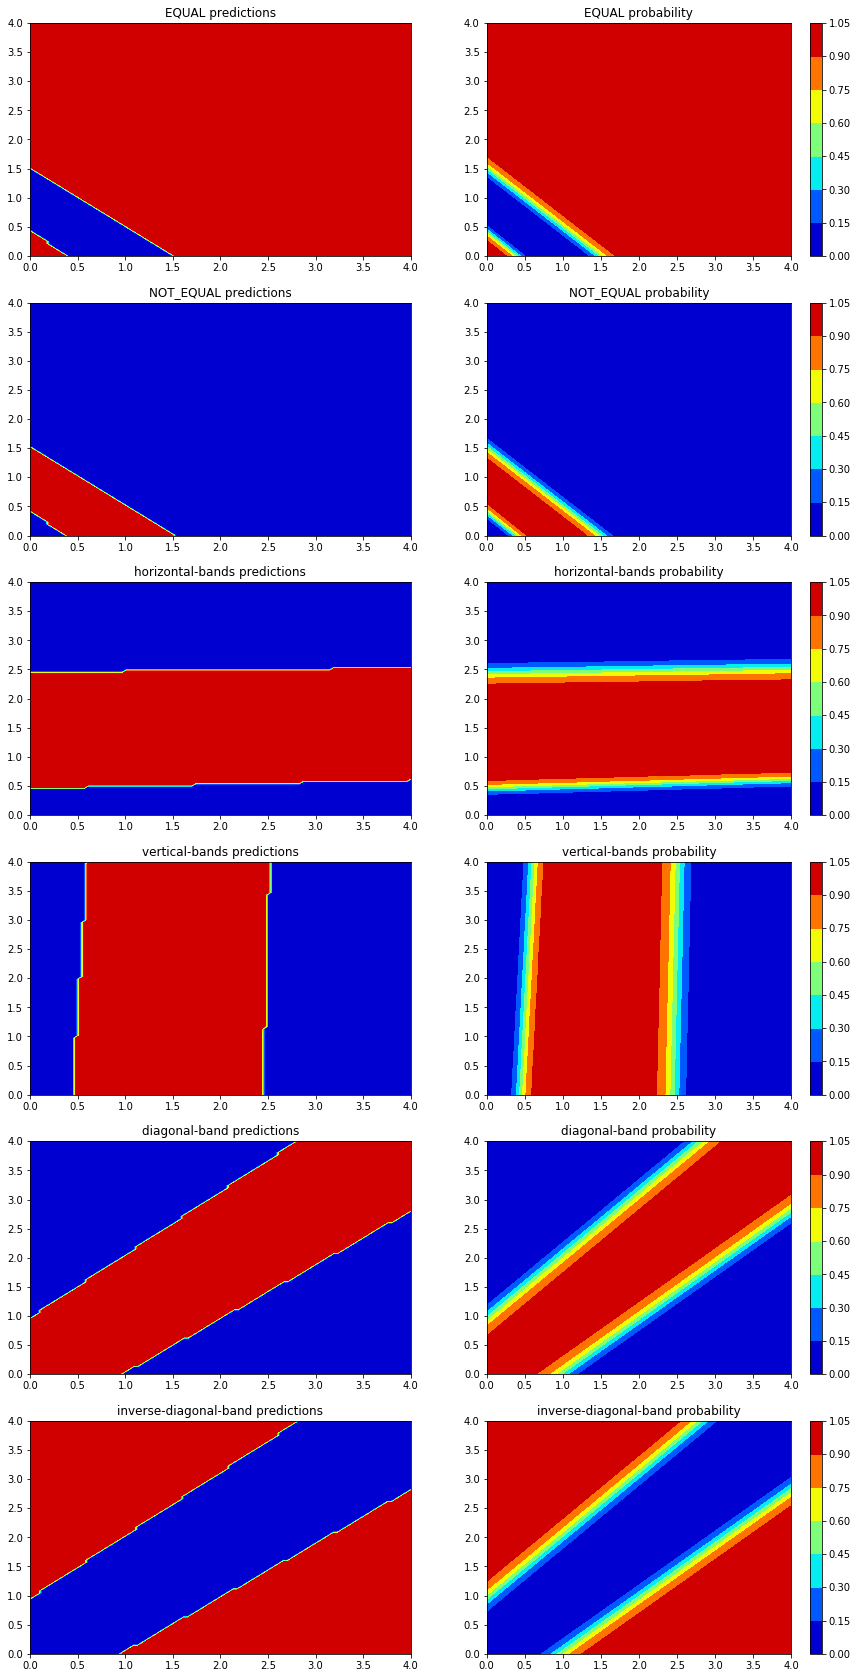

In [13]:
plt.subplots(6, 2, figsize=(15, 30))
i = 1
for name, network in networks:
    ax = plt.subplot(6, 2, i)
    ax.set_title(f'{name} predictions')
    i+=1
    plot_decision_boundary(network, 0, 4, 0, 4, rounding=True)
    ax = plt.subplot(6, 2, i)
    ax.set_title(f'{name} probability')
    i+=1
    plot_decision_boundary(network, 0, 4, 0, 4, rounding=False)
plt.show()

## Regularization

### Make two moons network

At first we implement a method which returns a neural network with 40 neurons in hidden layer and a neuron for output.

In [19]:
def make_neural_net_two_moons():
    """
    Create an overparametrized network with 40 neurons in the first layer
    and a single neuron in the last. This network is more than enough to solve
    the two-moons dataset, and as a result will over-fit the data if trained
    excessively.

    See 'make_neural_net_basic' for required naming convention for inputs,
    weights, and neurons.
    """
    i0 = Input('i0', -1.0)
    i1 = Input('i1', 0.0)
    i2 = Input('i2', 0.0)
    inputs = [i0, i1, i2]
    
    
    seed_random()
    # First layer
    # weights : 
    first_layer_neurons = []
    for i in range(40):
        weights = []
        for j in range(3):
            weight = Weight(f'w{j}N{i}', random_weight())
            weights.append(weight)
        neuron = Neuron(f'N{i}', inputs, weights)
        first_layer_neurons.append(neuron)
        
    
    output_weights =[Weight(f'wN{i}NOutput', random_weight()) for i in range(40)]
    output_bias_weight=Weight(f'w0NOutput', random_weight())
    output_neuron = Neuron('NOutput', first_layer_neurons + [i0], output_weights + [output_bias_weight])
            
    P = PerformanceElem(output_neuron, 0.0)

    net = Network(P,first_layer_neurons + [output_neuron])       

    return net

Let check if our implementation is ok or not.

In [20]:
network = make_neural_net_two_moons()
does_implementation_is_ok_with_respect_to_finite_difference(network)

True

### Train and Test 
In this section we train our model on moons dataset with three number of itterations.

#### Train 

In [47]:
def train_two_moons(make_net_func, iterations=[100, 500, 1000]):
    networks = []
    for i in range(len(iterations)):
        for name, training_data, test_data in two_moons_data_set:
            network = make_net_func()
            train(network, training_data, rate=1.0, max_iterations=iterations[i],verbose=False)
            networks.append((name, network))  
    return networks

In [25]:
networks = train_two_moons(make_neural_net_two_moons)

[('two-moons', <__main__.Network at 0x11ab1c050>),
 ('two-moons', <__main__.Network at 0x11ddb9ed0>),
 ('two-moons', <__main__.Network at 0x11e48b950>)]

#### Test

In [95]:
import pandas as pd
def test_two_moons(networks):
    table = pd.DataFrame()
    for i in range(len(networks)):
        for name, training_data, test_data in two_moons_data_set:
            accuracy = test(networks[i][1], test_data, verbose=False)
            table[f'accuracy_{iterations[i]}'] = [accuracy] 
            print(f'Accuracy on datas in {iterations[i]} is {accuracy}')

            np_test = np.array(test_data)
            np_train = np.array(training_data)
            plt.subplots(1,2, figsize=(12.5, 5))
            plt.subplot(1,2,1)
            plot_decision_boundary(networks[i][1], -2, 2.5, -2, 2.5, rounding=True)
            plt.scatter(np_train[:, 0], np_train[:, 1], c = np_train[:, 2])
            plt.title(f'Train for {iterations[i]}')
            plt.subplot(1,2,2)
            plot_decision_boundary(networks[i][1], -2, 2.5, -2, 2.5, rounding=True)
            plt.scatter(np_test[:, 0], np_test[:, 1], c = np_test[:, 2])
            plt.title(f'Test for {iterations[i]}')
            plt.show()
    return table

Accuracy on datas in 100 is 0.99


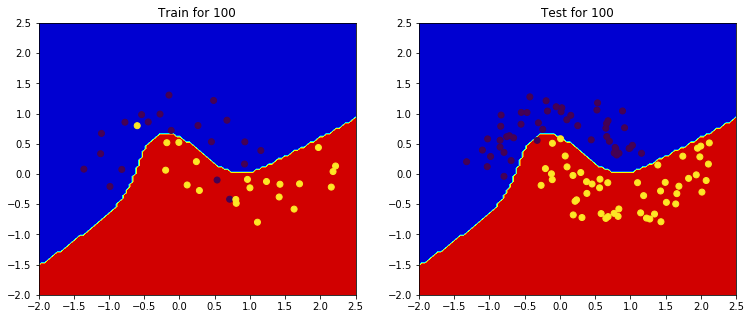

Accuracy on datas in 500 is 0.92


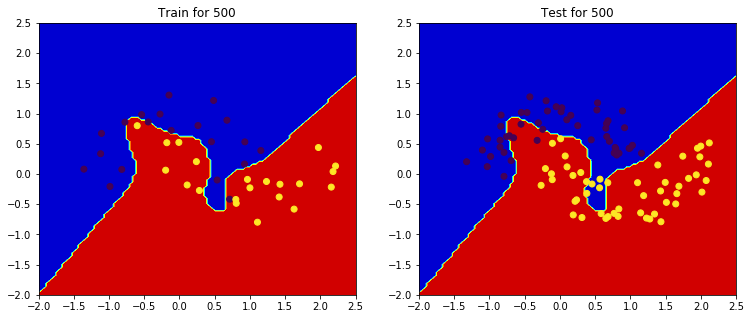

Accuracy on datas in 1000 is 0.9


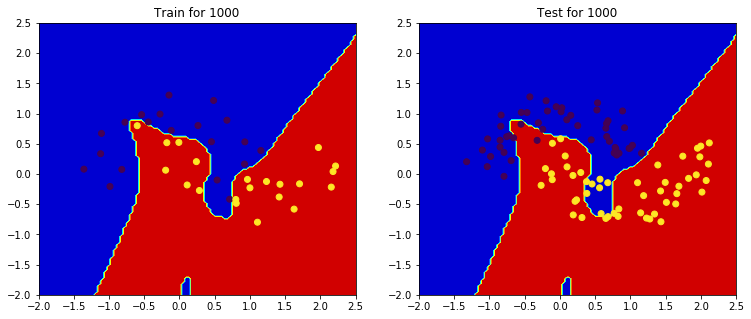

In [28]:
test_two_moonsonsonstest_two_moons(networks)

In [29]:
table

,accuracy_100,accuracy_500,accuracy_1000
0,0.99,0.92,0.9


As you see in 100 iterations, number of iteration is low and model doesnt overfit on outlier datas. Right plot is showing train data on decision boundry and you see there is a number of outliers which doesn't ocver correctly. but all test datas are in the trained positions and predicted correctly.

In case with 500 iterations, you see we had covered some of the outliers but not all of them and it fit with the train data more. 

In case with 1000 iterations we covered all of datas in train data and it includes outliers also. So, our model overfitted and can not predict some of test data correctly. 

### L2 Regularization Method

For regularization, we should change our output and dOutdX methods in performance element. From L2 formula we can say these function should rewrite again like this : 


$$
J_{L2}(W, b) = \frac{1}{m} \sum_{1}^{m}L(\hat y, y) + \lambda \sum_{j=1}^{n_x} w_j^2 = \frac{1}{2} (\text{d - o})^2  + \lambda \sum_{j=1}^{n_x} w_j^2 = \text{output}
$$

$$
\frac{d\text{out}}{d\text{w}} = (d - o) \times \frac{d\text{o}}{d\text{w}_i} - 2 \lambda w_i 
$$
After testing some diffrent lambda I got $10^{-4}$ is a good lambda for this data set.


For this goal we will create a new performance element class : 

In [96]:
class RegularizedPerformanceElem(DifferentiableElement):
    def __init__(self,input,desired_value, weights, _lambda = (10**-4)):
        assert isinstance(input,(Input,Neuron))
        DifferentiableElement.__init__(self)
        self.my_input = input
        self.my_desired_val = desired_value
        self._lambda = _lambda
        self.weights = weights
        

    def output(self):
        """
        Returns the output of this RegularizedPerformanceElem node.
        
        returns: number (float/int)
        """
        sum_of_weights = 0
        for weight in self.weights: sum_of_weights += weight.get_value()**2
        
        return -0.5*(self.my_desired_val - self.my_input.output()) ** 2 \
                            - self._lambda * sum_of_weights

    def dOutdX(self, elem):
        """
        Returns the derivative of this RegularizedPerformanceElem node with respect
        to some weight, given by elem.

        elem: an instance of Weight

        returns: number (int/float)
        """
        return 0.5* 2 * (self.my_desired_val - self.my_input.output()) * self.my_input.dOutdX(elem) \
                            - 2 * self._lambda * elem.get_value()

    def set_desired(self,new_desired):
        self.my_desired_val = new_desired

    def get_input(self):
        return self.my_input

We should also create our network again. For that, we just change our last performance element and pass all weights to it. 

In [97]:
def make_regularized_neural_net_two_moons():
    """
    Create an overparametrized network with 40 neurons in the first layer
    and a single neuron in the last. This network is more than enough to solve
    the two-moons dataset, and as a result will over-fit the data if trained
    excessively.

    See 'make_neural_net_basic' for required naming convention for inputs,
    weights, and neurons.
    """
    i0 = Input('i0', -1.0)
    i1 = Input('i1', 0.0)
    i2 = Input('i2', 0.0)
    inputs = [i0, i1, i2]
    
    
    seed_random()
    # First layer
    # weights : 
    first_layer_wights = []
    first_layer_neurons = []
    for i in range(40):
        weights = []
        for j in range(3):
            weight = Weight(f'w{j}N{i}', random_weight())
            weights.append(weight)
            first_layer_wights.append(weight)
        neuron = Neuron(f'N{i}', inputs, weights)
        first_layer_neurons.append(neuron)
        
    
    output_weights =[Weight(f'wN{i}NOutput', random_weight()) for i in range(40)]
    output_bias_weight=Weight(f'w0NOutput', random_weight())
    output_neuron = Neuron('NOutput', first_layer_neurons + [i0], output_weights + [output_bias_weight])
            
    P = RegularizedPerformanceElem(output_neuron, 0.0, weights=first_layer_wights+output_weights+[output_bias_weight])

    net = Network(P,first_layer_neurons + [output_neuron])       

    return net

Let see if our network is ok or not

In [98]:
network = make_regularized_neural_net_two_moons()
does_implementation_is_ok_with_respect_to_finite_difference(network)

True

If we train this network with three different max iterations we got something like this : 

In [99]:
networks = train_two_moons(make_regularized_neural_net_two_moons, iterations=[100, 500, 1000])

Accuracy on datas in 100 is 0.97


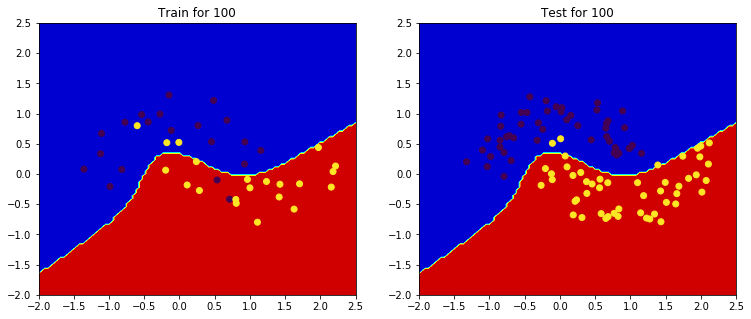

Accuracy on datas in 500 is 0.98


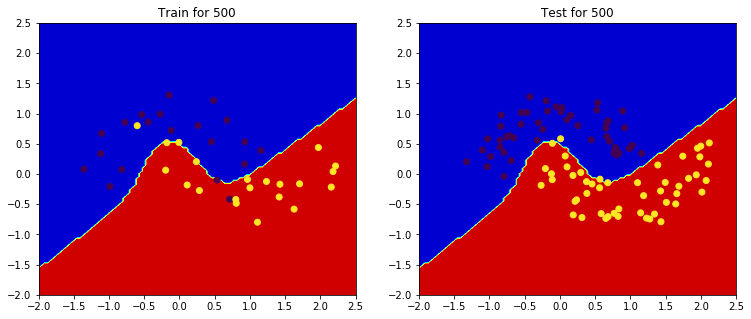

Accuracy on datas in 1000 is 0.97


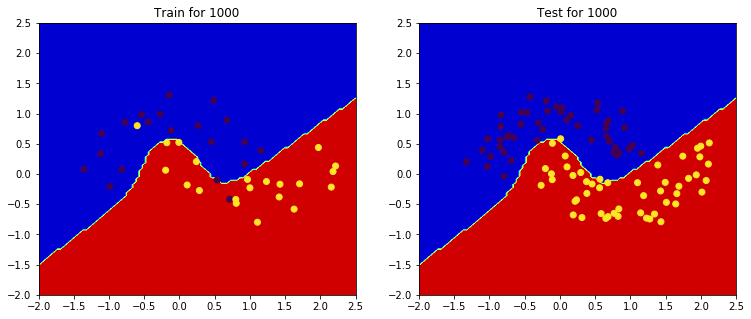

,accuracy_100,accuracy_500,accuracy_1000
0,0.97,0.98,0.97


In [100]:
test_two_moons(networks)

As you see we got similar results in these three diffrent iterations. It is because our network doesn't overfit over increasing number of iterations. 

This operation decrease overfiting because after some iterations performance change in very low varations and decrease overfiting. In fact,  L2 add a penalty value to our performance with a lambda coeff. As you see if this coeff was zero we got our first performance element. This coeff always subtract some value from the original value and does not let this performance to gor lower. So, we can say these kind of performance can decrease overfiting.
